# Test des Image Preprocessing Transformers

Ce notebook teste tous les transformers du module `image_preprocessing` avec le dataset COVID-19.

## 1. Configuration et Imports

In [3]:
import sys
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

# # Ajouter le répertoire src au path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.features.Pipelines.transformateurs.image_loaders import ImageLoader
from src.features.Pipelines.transformateurs.image_preprocessing import (
    ImageResizer,
    ImageNormalizer,
    ImageMasker,
    ImageFlattener,
    ImageBinarizer
)

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

print(f"Project root: {project_root}")
print("✓ Imports réussis")

Project root: /home/cepa/DST/projet_DS/DS_COVID_ORGA
✓ Imports réussis


## 2. Chargement des données de test

In [4]:
# Charger un échantillon d'images
data_root = project_root / "data" / "raw" / "COVID-19_Radiography_Dataset" / "COVID-19_Radiography_Dataset"


# Trouver les dossiers d'images
image_folders = list(data_root.glob('*/images'))
print(f"Dossiers trouvés: {len(image_folders)}")

# Collecter des chemins d'images
image_paths = []
mask_paths = []
labels = []

n_samples_per_category = 50
for img_folder in image_folders:
    category_name = img_folder.parent.name
    mask_folder = img_folder.parent / "masks"
    
    # Récupérer les images
    img_files = sorted(list(img_folder.glob('*.png')))[:n_samples_per_category]
    
    for img_file in img_files:
        image_paths.append(img_file)
        labels.append(category_name)
        
        # Trouver le masque correspondant
        mask_file = mask_folder / img_file.name
        if mask_file.exists():
            mask_paths.append(mask_file)
        else:
            mask_paths.append(None)

print(f"\nTotal images: {len(image_paths)}")
print(f"Catégories: {set(labels)}")
print(f"Masques disponibles: {sum(1 for m in mask_paths if m is not None)}")

Dossiers trouvés: 4

Total images: 200
Catégories: {'Viral Pneumonia', 'Normal', 'Lung_Opacity', 'COVID'}
Masques disponibles: 200


In [6]:
# Charger les images avec ImageLoader
loader = ImageLoader(color_mode='L', verbose=True)
images = loader.transform(image_paths[:20])  # 20 images pour les tests

print(f"\nImages chargées: {len(images)}")
print(f"Type: {type(images[0])}")
print(f"Taille première image: {images[0].size}")

2026-01-07 22:25:35,491 - src.features.Pipelines.transformateurs.image_loaders - INFO - Loading 20 images...
Loading images: 100%|██████████| 20/20 [00:00<00:00, 386.55it/s]
2026-01-07 22:25:35,550 - src.features.Pipelines.transformateurs.image_loaders - INFO - Loading completed: 20/20 images loaded successfully (100.0%)



Images chargées: 20
Type: <class 'PIL.Image.Image'>
Taille première image: (299, 299)


## 3. Test ImageResizer

In [7]:
print("="*70)
print("TEST 1: ImageResizer - Redimensionnement standard")
print("="*70)

resizer = ImageResizer(img_size=(256, 256), verbose=True)
images_resized = resizer.fit_transform(images[:10])

print(f"\nShape après resize: {images_resized.shape}")
print(f"Dtype: {images_resized.dtype}")
print(f"Range: [{images_resized.min()}, {images_resized.max()}]")

2026-01-07 22:25:45,880 - src.features.Pipelines.transformateurs.image_preprocessing - INFO - Resizing 10 images to (256, 256)


TEST 1: ImageResizer - Redimensionnement standard


Resizing images: 100%|██████████| 10/10 [00:00<00:00, 545.66it/s]
2026-01-07 22:25:45,908 - src.features.Pipelines.transformateurs.image_preprocessing - INFO - Resizing completed: 10 images processed



Shape après resize: (10, 256, 256)
Dtype: uint8
Range: [0, 255]


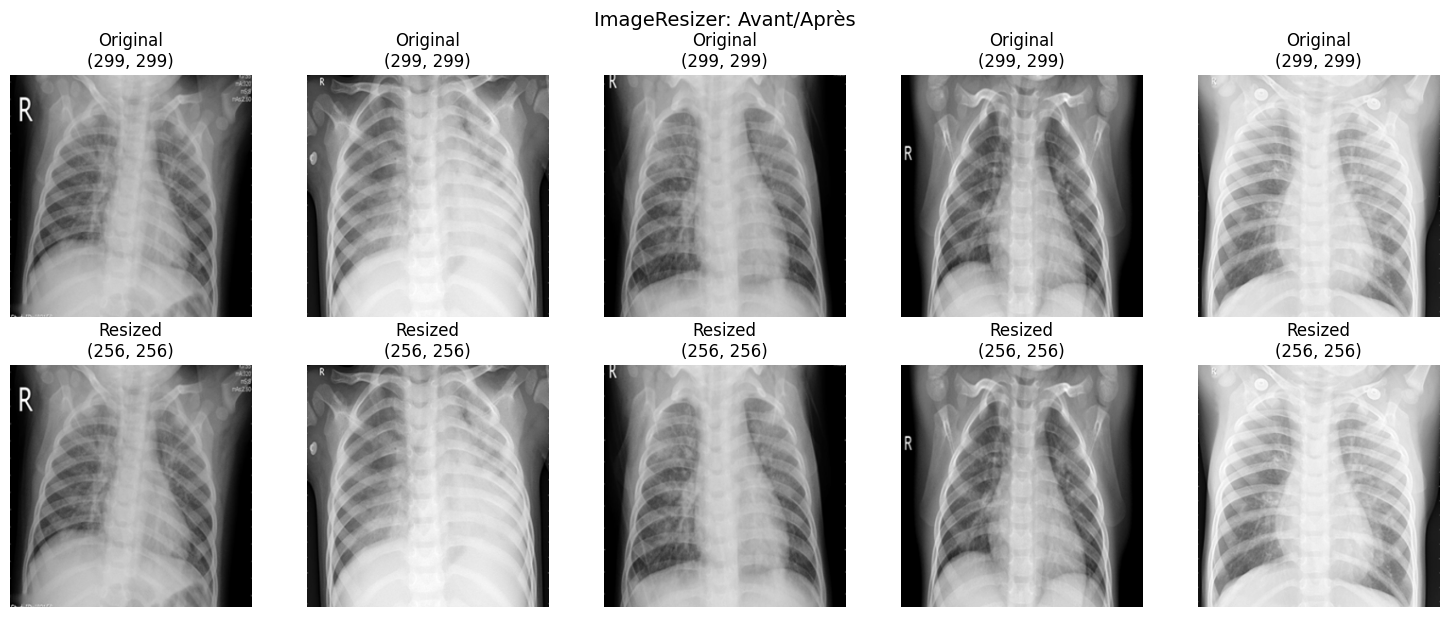

In [5]:
# Visualisation
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx in range(5):
    # Original
    axes[0, idx].imshow(images[idx], cmap='gray')
    axes[0, idx].set_title(f'Original\n{images[idx].size}')
    axes[0, idx].axis('off')
    
    # Resized
    axes[1, idx].imshow(images_resized[idx], cmap='gray')
    axes[1, idx].set_title(f'Resized\n{images_resized[idx].shape}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.suptitle('ImageResizer: Avant/Après', fontsize=14, y=1.02)
plt.show()

2026-01-07 22:26:43,783 - src.features.Pipelines.transformateurs.image_preprocessing - INFO - Resizing 5 images to (12, 12)


TEST 2: ImageResizer - Avec préservation du ratio


Resizing images: 100%|██████████| 5/5 [00:00<00:00, 698.45it/s]
2026-01-07 22:26:43,805 - src.features.Pipelines.transformateurs.image_preprocessing - INFO - Resizing completed: 5 images processed


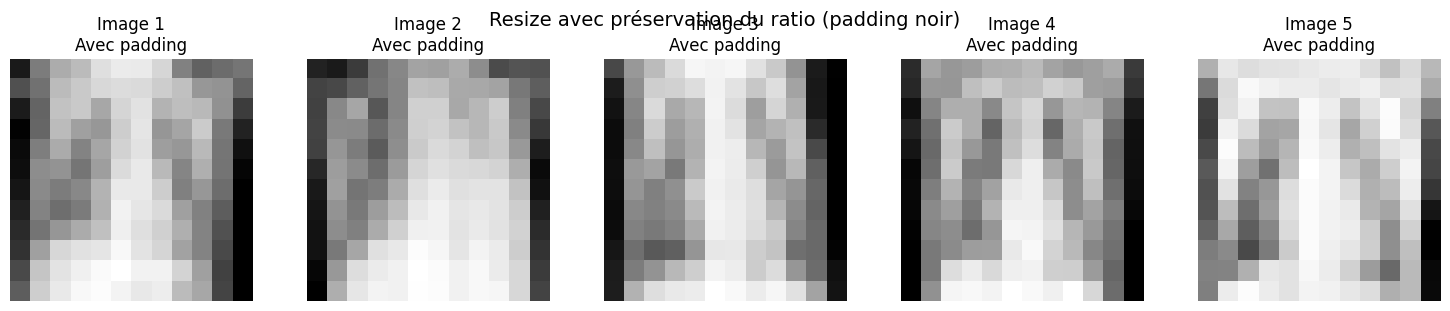

In [9]:
print("="*70)
print("TEST 2: ImageResizer - Avec préservation du ratio")
print("="*70)

resizer_aspect = ImageResizer(
    img_size=(12, 12),
    preserve_aspect_ratio=True,
    verbose=True
)
images_aspect = resizer_aspect.fit_transform(images[:5])

# Visualisation
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for idx in range(5):
    axes[idx].imshow(images_aspect[idx], cmap='gray')
    axes[idx].set_title(f'Image {idx+1}\nAvec padding')
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Resize avec préservation du ratio (padding noir)', fontsize=14, y=1.02)
plt.show()

## 4. Test ImageNormalizer

In [7]:
print("="*70)
print("TEST 3: ImageNormalizer - MinMax (0-1)")
print("="*70)

normalizer_minmax = ImageNormalizer(method='minmax', per_image=False, verbose=True)
images_norm_minmax = normalizer_minmax.fit_transform(images_resized[:10])

print(f"\nShape: {images_norm_minmax.shape}")
print(f"Range: [{images_norm_minmax.min():.4f}, {images_norm_minmax.max():.4f}]")
print(f"Mean: {images_norm_minmax.mean():.4f}")
print(f"Std: {images_norm_minmax.std():.4f}")

2025-11-05 11:02:17,160 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Fitted normalizer with method 'minmax'
2025-11-05 11:02:17,163 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Global range: [0.00, 255.00]
2025-11-05 11:02:17,165 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalizing 10 images using 'minmax' method...
2025-11-05 11:02:17,163 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Global range: [0.00, 255.00]
2025-11-05 11:02:17,165 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalizing 10 images using 'minmax' method...
2025-11-05 11:02:17,181 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalization completed. Output range: [0.00, 1.00]
2025-11-05 11:02:17,181 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalization completed. Output range: [0.00, 1.00]


TEST 3: ImageNormalizer - MinMax (0-1)

Shape: (10, 256, 256)
Range: [0.0000, 1.0000]
Mean: 0.4982
Std: 0.2295


In [8]:
print("="*70)
print("TEST 4: ImageNormalizer - Standardization (z-score)")
print("="*70)

normalizer_std = ImageNormalizer(method='standard', per_image=False, verbose=True)
images_norm_std = normalizer_std.fit_transform(images_resized[:10])

print(f"\nShape: {images_norm_std.shape}")
print(f"Range: [{images_norm_std.min():.4f}, {images_norm_std.max():.4f}]")
print(f"Mean: {images_norm_std.mean():.4f} (devrait être ~0)")
print(f"Std: {images_norm_std.std():.4f} (devrait être ~1)")

2025-11-05 11:02:23,919 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Fitted normalizer with method 'standard'
2025-11-05 11:02:23,923 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Global stats: mean=127.05, std=58.51
2025-11-05 11:02:23,929 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalizing 10 images using 'standard' method...
2025-11-05 11:02:23,923 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Global stats: mean=127.05, std=58.51
2025-11-05 11:02:23,929 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalizing 10 images using 'standard' method...
2025-11-05 11:02:23,946 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalization completed. Output range: [-2.17, 2.19]
2025-11-05 11:02:23,946 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalization completed. Output range: [-2.17, 2.19]


TEST 4: ImageNormalizer - Standardization (z-score)

Shape: (10, 256, 256)
Range: [-2.1714, 2.1868]
Mean: -0.0000 (devrait être ~0)
Std: 1.0000 (devrait être ~1)


In [9]:
print("="*70)
print("TEST 5: ImageNormalizer - Custom range (-1, 1)")
print("="*70)

normalizer_custom = ImageNormalizer(
    method='custom',
    feature_range=(-1, 1),
    per_image=False,
    verbose=True
)
images_norm_custom = normalizer_custom.fit_transform(images_resized[:10])

print(f"\nRange: [{images_norm_custom.min():.4f}, {images_norm_custom.max():.4f}]")

2025-11-05 11:03:55,694 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Fitted normalizer with method 'custom'
2025-11-05 11:03:55,697 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Global range: [0.00, 255.00]
2025-11-05 11:03:55,698 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalizing 10 images using 'custom' method...
2025-11-05 11:03:55,697 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Global range: [0.00, 255.00]
2025-11-05 11:03:55,698 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalizing 10 images using 'custom' method...
2025-11-05 11:03:55,714 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalization completed. Output range: [-1.00, 1.00]
2025-11-05 11:03:55,714 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Normalization completed. Output range: [-1.00, 1.00]


TEST 5: ImageNormalizer - Custom range (-1, 1)

Range: [-1.0000, 1.0000]


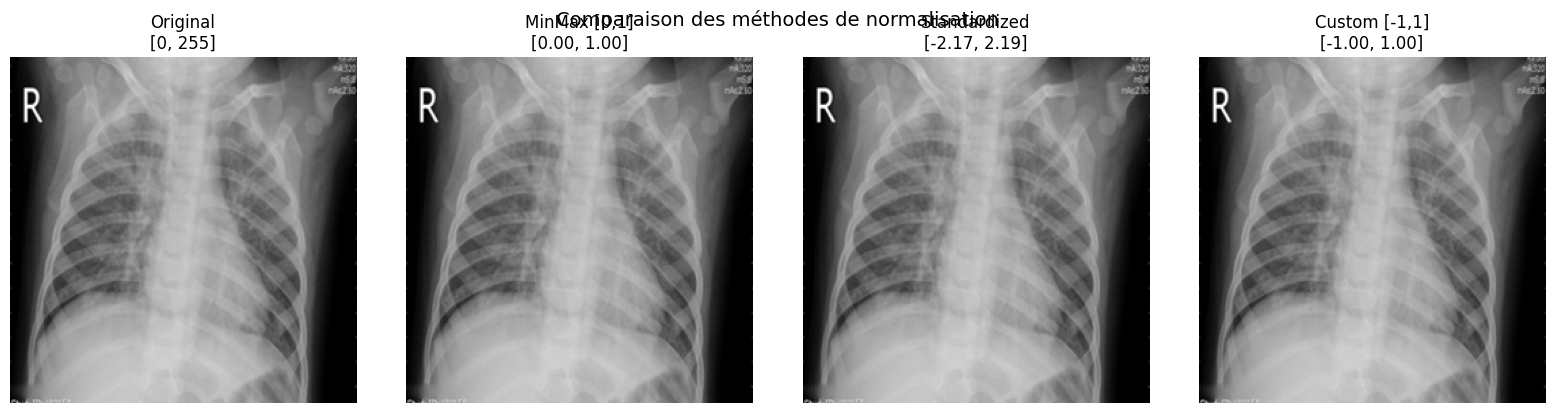

In [10]:
# Comparaison visuelle des normalisations
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(images_resized[0], cmap='gray')
axes[0].set_title(f'Original\n[{images_resized[0].min()}, {images_resized[0].max()}]')
axes[0].axis('off')

axes[1].imshow(images_norm_minmax[0], cmap='gray')
axes[1].set_title(f'MinMax [0,1]\n[{images_norm_minmax[0].min():.2f}, {images_norm_minmax[0].max():.2f}]')
axes[1].axis('off')

axes[2].imshow(images_norm_std[0], cmap='gray')
axes[2].set_title(f'Standardized\n[{images_norm_std[0].min():.2f}, {images_norm_std[0].max():.2f}]')
axes[2].axis('off')

axes[3].imshow(images_norm_custom[0], cmap='gray', vmin=-1, vmax=1)
axes[3].set_title(f'Custom [-1,1]\n[{images_norm_custom[0].min():.2f}, {images_norm_custom[0].max():.2f}]')
axes[3].axis('off')

plt.tight_layout()
plt.suptitle('Comparaison des méthodes de normalisation', fontsize=14, y=1.02)
plt.show()

## 5. Test ImageMasker

In [11]:
# Filtrer pour avoir seulement les images avec masques
images_with_masks = []
paths_with_masks = []
valid_mask_paths = []

for i, (img_path, mask_path) in enumerate(zip(image_paths[:20], mask_paths[:20])):
    if mask_path is not None:
        images_with_masks.append(images[i])
        paths_with_masks.append(img_path)
        valid_mask_paths.append(mask_path)

print(f"Images avec masques disponibles: {len(images_with_masks)}")

if len(images_with_masks) > 0:
    print("="*70)
    print("TEST 6: ImageMasker - Application de masques")
    print("="*70)
    
    # Redimensionner d'abord
    resizer = ImageResizer(img_size=(256, 256), verbose=False)
    images_for_mask = resizer.fit_transform(images_with_masks[:5])
    
    # Appliquer les masques
    masker = ImageMasker(
        mask_paths=valid_mask_paths[:5],
        mask_threshold=0.5,
        resize_masks=True,
        verbose=True
    )
    images_masked = masker.fit_transform(images_for_mask)
    
    print(f"\nImages masquées: {images_masked.shape}")
else:
    print("⚠️ Aucun masque disponible pour les tests")

2025-11-05 11:04:19,124 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Applying masks to 5 images...


Images avec masques disponibles: 20
TEST 6: ImageMasker - Application de masques


Applying masks: 100%|██████████| 5/5 [00:00<00:00, 158.50it/s]
2025-11-05 11:04:19,168 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Masking completed: 5 images processed
Applying masks: 100%|██████████| 5/5 [00:00<00:00, 158.50it/s]
2025-11-05 11:04:19,168 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Masking completed: 5 images processed



Images masquées: (5, 256, 256)


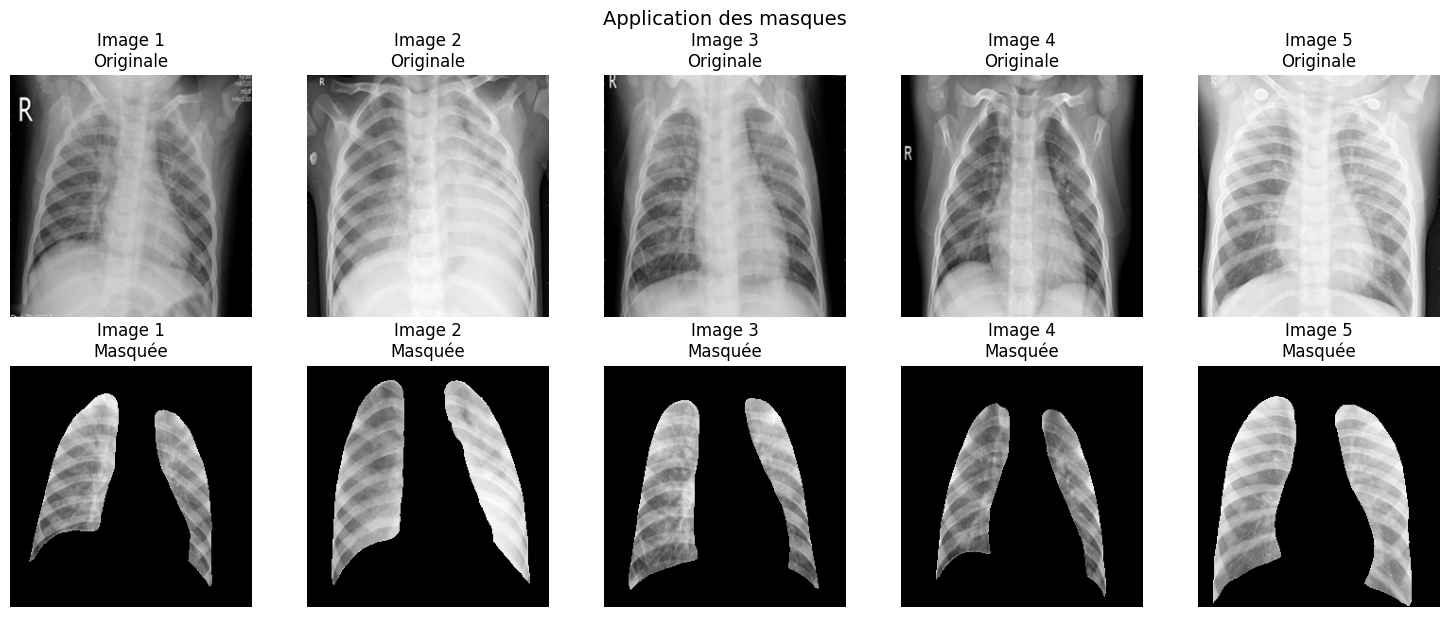

In [12]:
# Visualisation des masques
if len(images_with_masks) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for idx in range(min(5, len(images_masked))):
        # Image originale
        axes[0, idx].imshow(images_for_mask[idx], cmap='gray')
        axes[0, idx].set_title(f'Image {idx+1}\nOriginale')
        axes[0, idx].axis('off')
        
        # Image masquée
        axes[1, idx].imshow(images_masked[idx], cmap='gray')
        axes[1, idx].set_title(f'Image {idx+1}\nMasquée')
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Application des masques', fontsize=14, y=1.02)
    plt.show()

## 6. Test ImageFlattener

In [13]:
print("="*70)
print("TEST 7: ImageFlattener - Aplatissement et reconstruction")
print("="*70)

flattener = ImageFlattener(order='C', verbose=True)
images_flat = flattener.fit_transform(images_resized[:10])

print(f"\nShape aplatie: {images_flat.shape}")
print(f"Nombre de features par image: {flattener.n_features_}")
print(f"Shape originale: {flattener.original_shape_}")

2025-11-05 11:04:35,797 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Fitted flattener: (256, 256) -> 65536 features
2025-11-05 11:04:35,803 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Flattening 10 images...
2025-11-05 11:04:35,807 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Flattening completed: (10, 256, 256) -> (10, 65536)
2025-11-05 11:04:35,803 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Flattening 10 images...
2025-11-05 11:04:35,807 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Flattening completed: (10, 256, 256) -> (10, 65536)


TEST 7: ImageFlattener - Aplatissement et reconstruction

Shape aplatie: (10, 65536)
Nombre de features par image: 65536
Shape originale: (256, 256)


Shape reconstruite: (10, 256, 256)
Reconstruction identique: True


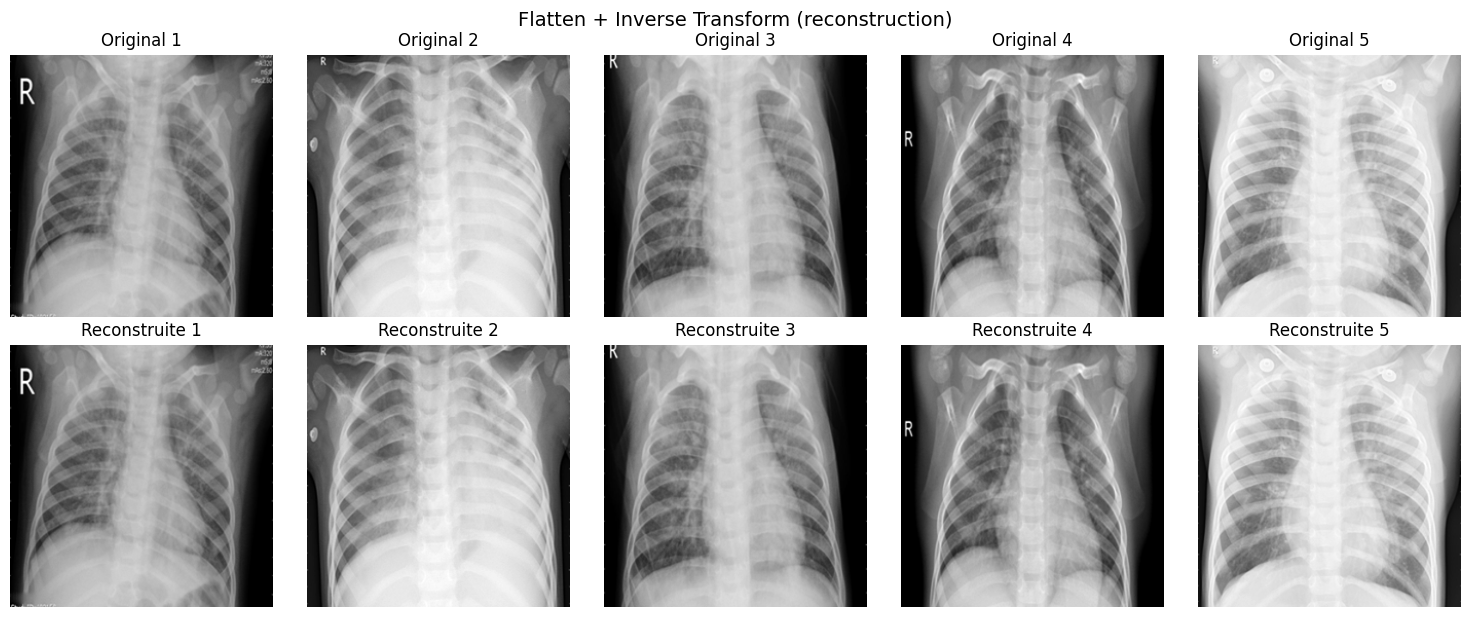

In [14]:
# Test de la reconstruction inverse
images_reconstructed = flattener.inverse_transform(images_flat)

print(f"Shape reconstruite: {images_reconstructed.shape}")
print(f"Reconstruction identique: {np.allclose(images_reconstructed, images_resized[:10])}")

# Visualisation
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx in range(5):
    # Original
    axes[0, idx].imshow(images_resized[idx], cmap='gray')
    axes[0, idx].set_title(f'Original {idx+1}')
    axes[0, idx].axis('off')
    
    # Reconstructed
    axes[1, idx].imshow(images_reconstructed[idx], cmap='gray')
    axes[1, idx].set_title(f'Reconstruite {idx+1}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.suptitle('Flatten + Inverse Transform (reconstruction)', fontsize=14, y=1.02)
plt.show()

## 7. Test ImageBinarizer

In [15]:
print("="*70)
print("TEST 8: ImageBinarizer - Seuil fixe")
print("="*70)

binarizer_fixed = ImageBinarizer(threshold=0.5, verbose=True)
images_bin_fixed = binarizer_fixed.fit_transform(images_norm_minmax)

print(f"\nShape: {images_bin_fixed.shape}")
print(f"Valeurs uniques: {np.unique(images_bin_fixed)}")

2025-11-05 11:05:14,981 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Fitted binarizer with threshold: 0.5000
2025-11-05 11:05:14,986 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarizing 10 images with threshold 0.5000
2025-11-05 11:05:14,996 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarization completed. Positive pixels: 56.6%
2025-11-05 11:05:14,986 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarizing 10 images with threshold 0.5000
2025-11-05 11:05:14,996 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarization completed. Positive pixels: 56.6%


TEST 8: ImageBinarizer - Seuil fixe

Shape: (10, 256, 256)
Valeurs uniques: [0. 1.]


In [16]:
print("="*70)
print("TEST 9: ImageBinarizer - Méthode Otsu")
print("="*70)

binarizer_otsu = ImageBinarizer(threshold='otsu', verbose=True)
images_bin_otsu = binarizer_otsu.fit_transform(images_norm_minmax)

print(f"\nSeuil calculé (Otsu): {binarizer_otsu.threshold_value_:.4f}")

2025-11-05 11:05:19,133 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Fitted binarizer with threshold: 0.4238
2025-11-05 11:05:19,138 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarizing 10 images with threshold 0.4238
2025-11-05 11:05:19,138 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarizing 10 images with threshold 0.4238
2025-11-05 11:05:19,149 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarization completed. Positive pixels: 68.0%
2025-11-05 11:05:19,149 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarization completed. Positive pixels: 68.0%


TEST 9: ImageBinarizer - Méthode Otsu

Seuil calculé (Otsu): 0.4238


In [17]:
print("="*70)
print("TEST 10: ImageBinarizer - Méthode Mean")
print("="*70)

binarizer_mean = ImageBinarizer(threshold='mean', verbose=True)
images_bin_mean = binarizer_mean.fit_transform(images_norm_minmax)

print(f"\nSeuil calculé (Mean): {binarizer_mean.threshold_value_:.4f}")

2025-11-05 11:05:27,955 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Fitted binarizer with threshold: 0.4982
2025-11-05 11:05:27,959 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarizing 10 images with threshold 0.4982
2025-11-05 11:05:27,959 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarizing 10 images with threshold 0.4982
2025-11-05 11:05:27,965 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarization completed. Positive pixels: 56.6%
2025-11-05 11:05:27,965 - src.features.Pipelines.Transformateurs.image_preprocessing - INFO - Binarization completed. Positive pixels: 56.6%


TEST 10: ImageBinarizer - Méthode Mean

Seuil calculé (Mean): 0.4982


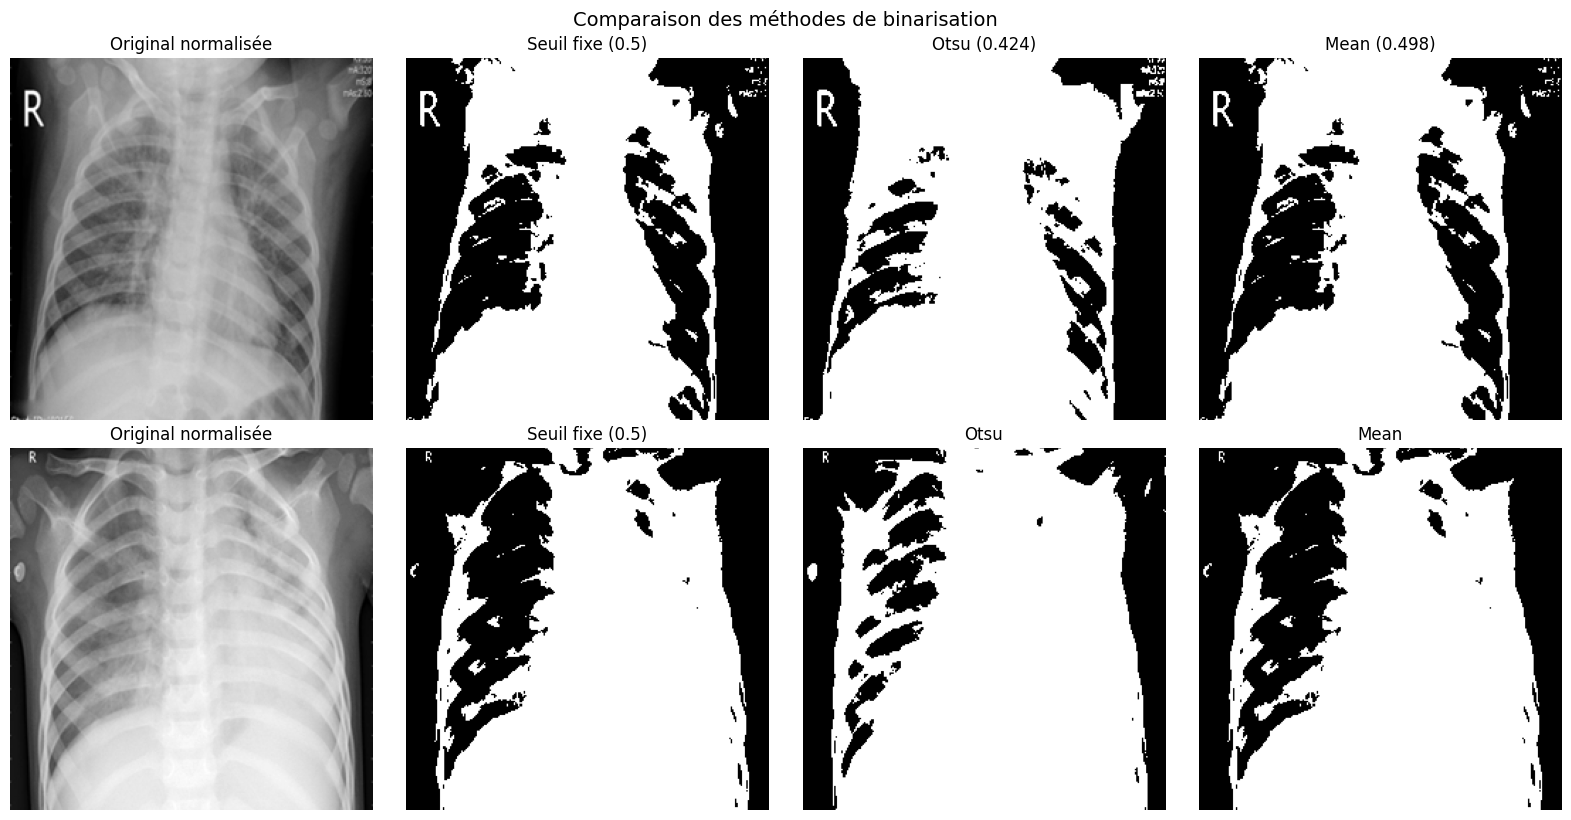

In [18]:
# Comparaison visuelle des binarisations
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

idx = 0  # Première image

# Ligne 1: Original et binarisations
axes[0, 0].imshow(images_norm_minmax[idx], cmap='gray')
axes[0, 0].set_title('Original normalisée')
axes[0, 0].axis('off')

axes[0, 1].imshow(images_bin_fixed[idx], cmap='gray')
axes[0, 1].set_title(f'Seuil fixe (0.5)')
axes[0, 1].axis('off')

axes[0, 2].imshow(images_bin_otsu[idx], cmap='gray')
axes[0, 2].set_title(f'Otsu ({binarizer_otsu.threshold_value_:.3f})')
axes[0, 2].axis('off')

axes[0, 3].imshow(images_bin_mean[idx], cmap='gray')
axes[0, 3].set_title(f'Mean ({binarizer_mean.threshold_value_:.3f})')
axes[0, 3].axis('off')

# Ligne 2: Deuxième image
idx = 1
axes[1, 0].imshow(images_norm_minmax[idx], cmap='gray')
axes[1, 0].set_title('Original normalisée')
axes[1, 0].axis('off')

axes[1, 1].imshow(images_bin_fixed[idx], cmap='gray')
axes[1, 1].set_title('Seuil fixe (0.5)')
axes[1, 1].axis('off')

axes[1, 2].imshow(images_bin_otsu[idx], cmap='gray')
axes[1, 2].set_title('Otsu')
axes[1, 2].axis('off')

axes[1, 3].imshow(images_bin_mean[idx], cmap='gray')
axes[1, 3].set_title('Mean')
axes[1, 3].axis('off')

plt.tight_layout()
plt.suptitle('Comparaison des méthodes de binarisation', fontsize=14, y=1.02)
plt.show()

## 8. Test Pipeline Complet

In [19]:
print("="*70)
print("TEST 11: Pipeline Complet - Sklearn Pipeline")
print("="*70)

# Créer un pipeline complet
pipeline = Pipeline([
    ('loader', ImageLoader(color_mode='L', verbose=False)),
    ('resizer', ImageResizer(img_size=(128, 128), verbose=False)),
    ('normalizer', ImageNormalizer(method='minmax', verbose=False)),
    ('binarizer', ImageBinarizer(threshold='otsu', verbose=False)),
    ('flattener', ImageFlattener(verbose=False))
])

# Exécuter le pipeline
print("\nExécution du pipeline...")
X_processed = pipeline.fit_transform(image_paths[:20])

print(f"\nRésultat final:")
print(f"  Shape: {X_processed.shape}")
print(f"  Dtype: {X_processed.dtype}")
print(f"  Range: [{X_processed.min()}, {X_processed.max()}]")
print(f"  Nombre d'échantillons: {X_processed.shape[0]}")
print(f"  Nombre de features: {X_processed.shape[1]}")
print(f"\n✓ Pipeline exécuté avec succès!")

TEST 11: Pipeline Complet - Sklearn Pipeline

Exécution du pipeline...

Résultat final:
  Shape: (20, 16384)
  Dtype: float32
  Range: [0.0, 1.0]
  Nombre d'échantillons: 20
  Nombre de features: 16384

✓ Pipeline exécuté avec succès!


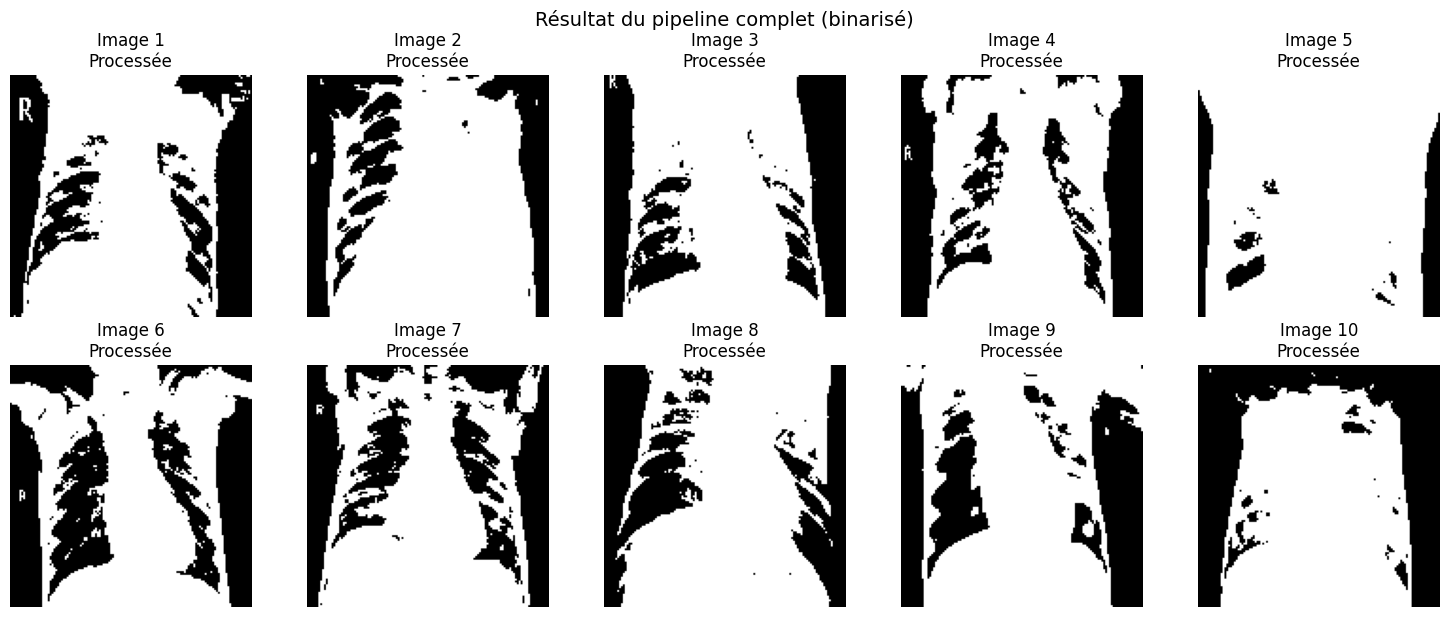

In [20]:
# Visualiser quelques résultats du pipeline
# Reconstruire les images pour visualisation
img_shape = (128, 128)
reconstructed = X_processed.reshape(-1, *img_shape)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx in range(10):
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(reconstructed[idx], cmap='gray')
    axes[row, col].set_title(f'Image {idx+1}\nProcessée')
    axes[row, col].axis('off')

plt.tight_layout()
plt.suptitle('Résultat du pipeline complet (binarisé)', fontsize=14, y=1.02)
plt.show()

## 9. Résumé des Tests

In [21]:
print("\n" + "="*70)
print("RÉSUMÉ DES TESTS - Image Preprocessing")
print("="*70)

print("\n✓ ImageResizer")
print("  - Redimensionnement standard: OK")
print("  - Préservation du ratio avec padding: OK")
print("  - Multiple interpolation methods: OK")

print("\n✓ ImageNormalizer")
print("  - MinMax [0,1]: OK")
print("  - Standardization (z-score): OK")
print("  - Custom range [-1,1]: OK")
print("  - Per-image vs global: OK")

print("\n✓ ImageMasker")
if len(images_with_masks) > 0:
    print("  - Application de masques: OK")
    print("  - Redimensionnement automatique: OK")
    print("  - Gestion d'erreurs: OK")
else:
    print("  - Non testé (pas de masques disponibles)")

print("\n✓ ImageFlattener")
print("  - Aplatissement: OK")
print("  - Inverse transform: OK")
print("  - Conservation des données: OK")

print("\n✓ ImageBinarizer")
print("  - Seuil fixe: OK")
print("  - Méthode Otsu: OK")
print("  - Méthode Mean: OK")
print("  - Méthode Median: Disponible")

print("\n✓ Pipeline sklearn")
print("  - Intégration complète: OK")
print("  - Fit/Transform: OK")
print("  - Chaînage: OK")

print("\n" + "="*70)
print("TOUS LES TESTS RÉUSSIS! 🎉")
print("="*70)


RÉSUMÉ DES TESTS - Image Preprocessing

✓ ImageResizer
  - Redimensionnement standard: OK
  - Préservation du ratio avec padding: OK
  - Multiple interpolation methods: OK

✓ ImageNormalizer
  - MinMax [0,1]: OK
  - Standardization (z-score): OK
  - Custom range [-1,1]: OK
  - Per-image vs global: OK

✓ ImageMasker
  - Application de masques: OK
  - Redimensionnement automatique: OK
  - Gestion d'erreurs: OK

✓ ImageFlattener
  - Aplatissement: OK
  - Inverse transform: OK
  - Conservation des données: OK

✓ ImageBinarizer
  - Seuil fixe: OK
  - Méthode Otsu: OK
  - Méthode Mean: OK
  - Méthode Median: Disponible

✓ Pipeline sklearn
  - Intégration complète: OK
  - Fit/Transform: OK
  - Chaînage: OK

TOUS LES TESTS RÉUSSIS! 🎉
